# Iteration 0 - CanIMarathon

In this project, the focus is on building, exploring and understanding the dataset used to build our marathon performance prediction system. The goal of this notebook is to load the training and performance data, perform a preliminary analysis to understand the relationships between physiological and physical metrics, training history, and race outcomes, and to build an initial regression model to predict marathon finishing time.

This will help us evaluate early results, identify any data issues and set a reference point for more advanced modeling in future iterations. By the end of this notebook, we aim to have a working model that gives us a rough estimate of performance and have an initial sense of feature importance.

Marathon performance is a highly individual outcome influenced by many variables — including training history, fitness level, fatigue and psychological endurance. Athletes are often analyzed using advanced physiological metrics like VO₂ max, lactate threshold, or heart rate variability.

In this iteration, we explore the possibility of predicting marathon performance using only data derived from previous runs, without any physiological or biometric inputs. Specifically, we investigate whether consistent patterns in distance, moving time, and pace across training runs can be used to estimate a runner’s potential marathon time.

First, the required libraries and imports are shown with their versions:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import requests
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
import seaborn as sns

print("pandas version: ", pd.__version__)
print("scikit-learn version:", sk.__version__)
print("numpy version:", np.__version__)
print("requests version:", requests.__version__)

pandas version:  2.2.3
scikit-learn version: 1.6.1
numpy version: 2.2.2
requests version: 2.32.3


# 📦 Data provisioning

The dataset used in this iteration was sourced from Strava’s API, utilizing personal training data for initial model development and testing. Strava offers detailed, structured activity data including distance, pace, elevation, and more - making it an ideal source for capturing the physiological and training-related factors, necessary for accurate marathon performance prediction.

To obtain the data, we authenticated using OAuth 2.0, as required by Strava. This involved generating an authorization code via the Strava OAuth flow, and exchanging it for a refresh token and a short-lived access token using a POST request. The data was then fetched using authenticated GET requests to relevant endpoints (e.g., /athlete, /activities), including the necessary headers with the bearer token. The process was replicated using Postman for easier visualization and testing.

Once retrieved, the activity data was exported in JSON format, converted to a structured CSV, and imported into this notebook for exploration and analysis. The data includes both physiological and training-specific metrics (e.g., cadence, average pace) over a span of multiple runs, which forms the foundation for our baseline model. In future iterations, we will expand this dataset with additional data from stakeholder athletes to improve model generalizability.

Here are the steps to collecting the data from the Strava API:

1. Create a Strava API Application - using my personal Strava account, I create a Strava API Application to gain access to the API

![API Application](images/strava_API_Application.png)

Now you have access to a "Client Secret", Access Token, Refresh Token and request analytics.

![API Settings](images/apiapp_settings.png)

2. Authorize the Athlete - we go to this link, to authorize the athlete using Strava's OAuth2 authentication.

![API Settings](images/authorization.png)

3. From the following page, we copy the code from the url into our code, it's to be done manually when initially doing it

![API Settings](images/auth_code.png)

4. After receiving our code, we run an authorization request to the API to get an access token we need for the next request

In [9]:
# Step 1: Set Strava API credentials
CLIENT_ID = "150056"
CLIENT_SECRET = "211e634d33ffa5eeeb3bcb444abf445bd0fd9822"
AUTH_CODE = "f14d86cf1941b28eca70f58595a09f7db5444a14"

# Step 2: Exchange authorization code for an access token
token_url = f"https://www.strava.com/oauth/token?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&code={AUTH_CODE}&grant_type=authorization_code"

response = requests.post(token_url)
token_data = response.json()

ACCESS_TOKEN = token_data["access_token"]

print(f"Access Token: {ACCESS_TOKEN}")

Access Token: aa2222a2bdc1b7edd6864973173a98b92bf4c136
Retrieved 30 activities.
Data saved to strava_activities.csv


5. We run a request to get all of the authorized athlete's activities. In this case it returns 30 activities.

In [ ]:
# Step 3: Get all activities using the access token
activities_url = f"https://www.strava.com/api/v3/athlete/activities?access_token={ACCESS_TOKEN}"

response = requests.get(activities_url)
activities = response.json()

print(f"Retrieved {len(activities)} activities.")

6. We save the activities in a cvs file, this is our dataset for this iteration.

In [ ]:
df = pd.DataFrame(activities)
df.to_csv("data/strava_activities.csv", index=False)

print("Data saved to strava_activities.csv")
print(df.head())

# Data Cleaning

Now that we have our data, we see that it's not normalized and the dataset contains values and data types that we won't need for our purposes.

To begin the analysis, the raw dataset containing Strava activity logs is loaded. It's then cleaned and normalized.

In [3]:
df = pd.read_csv("data/strava_activities.csv")

# Display initial info
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())

# Drop irrelevant columns
columns_to_drop = ['name', 'id', 'external_id', 'upload_id_str', 'start_date_local', 'timezone', 'resource_state', 'athlete', 'type', 'sport_type', 'workout_type', 'utc_offset', 'location_city', 'location_state', 'location_country', 'achievements', 'kudos_count', 'comment_count', 'athlete_count', 'photo_count', 'map', 'trainer', 'commute', 'manual', 'private', 'visibility', 'flagged', 'gear_id', 'start_latlng', 'end_latlng', 'has_heartrate', 'heartrate_opt_out', 'from_accepted_tag', 'pr_count', 'total_photo_count', 'has_kudoed', 'achievement_count', 'display_hide_heartrate_option', 'upload_id']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['start_date'] = df['start_date'].dt.date

df = df.dropna(subset=['distance', 'moving_time', 'elapsed_time', 'average_speed'])

# Drop rows with extreme outliers (if any) (e.g., distance > 100km or 0)
df = df[(df['distance'] > 1000) & (df['distance'] < 100000)]

df.to_csv("data/cleaned_strava_activities.csv", index=False)

print("Cleaned and normalized data saved as 'cleaned_strava_activities.csv'.")

df.sample(5)


Columns: ['resource_state', 'athlete', 'name', 'distance', 'moving_time', 'elapsed_time', 'total_elevation_gain', 'type', 'sport_type', 'workout_type', 'id', 'start_date', 'start_date_local', 'timezone', 'utc_offset', 'location_city', 'location_state', 'location_country', 'achievement_count', 'kudos_count', 'comment_count', 'athlete_count', 'photo_count', 'map', 'trainer', 'commute', 'manual', 'private', 'visibility', 'flagged', 'gear_id', 'start_latlng', 'end_latlng', 'average_speed', 'max_speed', 'has_heartrate', 'heartrate_opt_out', 'display_hide_heartrate_option', 'elev_high', 'elev_low', 'upload_id', 'upload_id_str', 'external_id', 'from_accepted_tag', 'pr_count', 'total_photo_count', 'has_kudoed', 'average_cadence']
Missing values:
 resource_state                    0
athlete                           0
name                              0
distance                          0
moving_time                       0
elapsed_time                      0
total_elevation_gain              0

,distance,moving_time,elapsed_time,total_elevation_gain,start_date,average_speed,max_speed,elev_high,elev_low,average_cadence
26,10046.9,4545,4660,95.6,2024-07-11,2.211,3.730,593.1,548.6,76.9
5,6845.2,2647,2772,12.4,2025-02-10,2.586,4.511,21.4,12.9,81.4
3,5241.8,1965,2096,8.3,2025-02-14,2.668,4.476,21.4,12.9,79.5
19,5004.2,1825,2027,2.3,2025-01-09,2.742,5.920,20.5,18.0,NaN
13,5078.6,1931,2046,0.0,2025-01-17,2.630,4.172,20.8,18.7,80.7


What we have gathered is a dataset with the runner's data of all his recorded runs on Strava. This will be the data used to make a prediction for this runner's performance in a marathon. Now we need to discover the correlations between the data to choose what we need and what we don't. For this purpose a heatmap is used to visualize the correlation between the dataq types in the dataset.



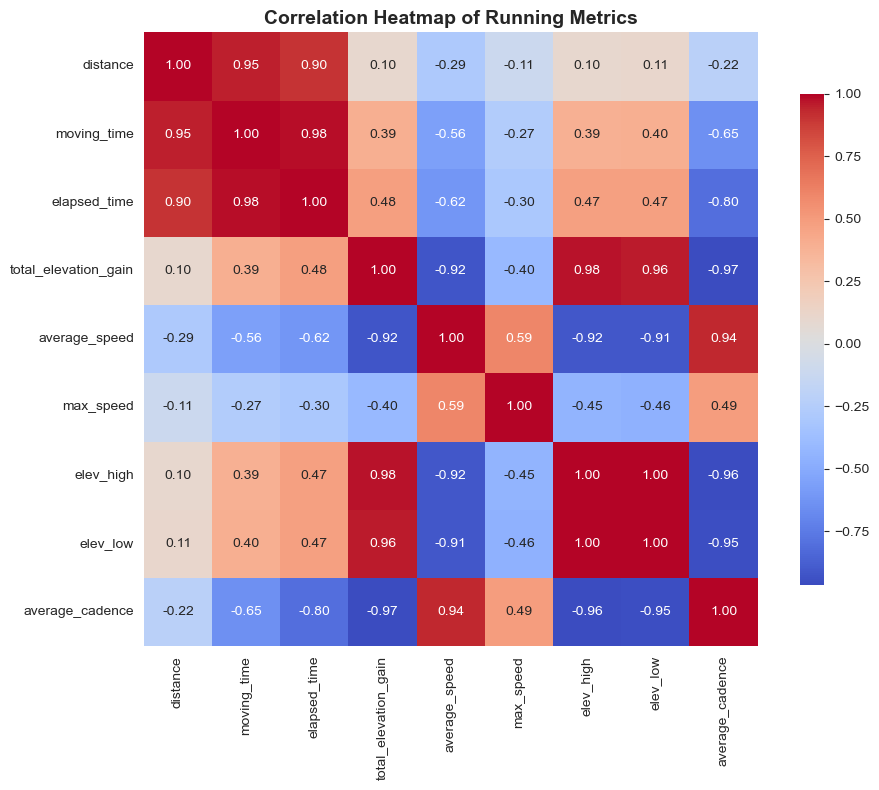

In [4]:
# Generate the correlation matrix
correlation_matrix = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap of Running Metrics", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

This correlation heatmap displays the linear relationships between original numerical variables collected from the runner’s Strava logs. Each value in the matrix ranges from -1 (strong negative correlation) to +1 (strong positive correlation)

Starting with distance and time metrics, there is a **very strong positive correlation** between **distance and moving time**, as well as elapsed time. This is expected and confirms that longer runs naturally require more time to complete. Additionally, moving time and elapsed time are almost **perfectly correlated**, suggesting that the runner takes very few breaks or pauses during sessions — an indication of steady, uninterrupted training.

When looking at elevation metrics, a moderate positive correlation appears between total elevation gain and both elev_high and elev_low. This indicates that runs with higher maximum elevations tend to include more climbing overall. However, elevation-related variables **do not show meaningful correlation with time, distance, or speed**, implying that elevation does not significantly influence performance in this dataset. This could mean the athlete trains predominantly on flat or consistent terrain.

In terms of speed-related metrics, **average speed has a strong negative correlation with both moving time and elapsed time**, meaning the longer the run, the slower the pace — which aligns with real-world fatigue behavior. There’s also a moderate negative correlation between average speed and distance, further supporting that longer efforts result in lower average speeds, an insight that can help model marathon slowdowns.

Max speed, on the other hand, shows only a moderate correlation with average speed, and weak correlation with distance or time. This suggests that peak speed might reflect short bursts or sprints rather than overall endurance, and therefore may not be helpful for marathon performance prediction. Lastly, average cadence demonstrates very weak correlation with any other metric. The runner appears to maintain a consistent cadence regardless of run length or speed, making it a low-impact feature in terms of predicting pace or time.

**Distance, moving time, and average speed** emerge as the most relevant indicators, while cadence, max speed, and elevation-related features are less influential for modeling marathon performance.

# Preprocessing

Before extracting meaningful insights, the raw data needs to be transformed into a more interpretable format. Based on prior domain research and best practices in sports analytics, we convert relevant units to make the dataset more intuitive and suitable for machine learning and understanding. Specifically, time fields such as moving_time and elapsed_time are converted from **seconds to minutes**, distance is converted from **meters to kilometers**, and average speed (originally in meters per second) is transformed into **pace (minutes per kilometer)**, which is a more intuitive measure of performance for runners.

In [5]:
# Convert time from seconds to minutes/hours, distance to kms and average speed to pace (min/km)
df['moving_time_min'] = df['moving_time'] / 60
df['elapsed_time_min'] = df['elapsed_time'] / 60
df['distance_km'] = df['distance'] / 1000
df['pace'] = (1 / df['average_speed']) / 60 * 1000

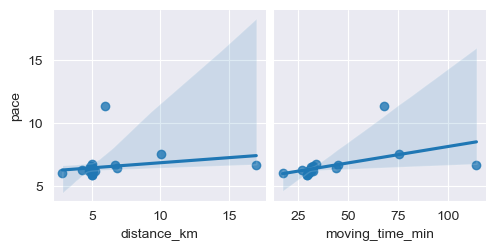

In [6]:
plot = sns.pairplot(df, x_vars=["distance_km", "moving_time_min"], y_vars="pace", kind="reg")

# Modeling

The goal of this section is to predict a runner’s expected pace and total finish time for a full marathon (42.195 km) using historical running data from Strava. The prediction is based on features available in every run log: **distance and moving time**. These two features are universally recorded and strongly correlated with pace.

We choose **Ridge Regression** for this task.

The dataset is small, which favors simple and stable models like it. The model must predict for a 42.2 km marathon, but all runs in our data are shorter. Tree-based models (like Random Forest or Decision Trees) struggle to extrapolate beyond the training range and Ridge, being a linear model, extends trendlines naturally, which makes it a solid choice for projecting longer distances *(Prior testing showed that Ridge Regression gave the most accurate and realistic marathon predictions compared to non-linear models like decision trees or k-nearest neighbors, which failed to generalize beyond the training range)*.

Our heatmap shows strong, mostly linear relationships between **pace, distance, and moving time**. This is perfect for Ridge, which assumes linearity but adds stability through regularization

In [7]:
X = df[['distance_km', 'moving_time_min']]
y = df['pace']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 30 observations, of which 24 are now in the train set, and 6 in the test set.


We first define the features (distance_km, moving_time_min) and the target variable (pace). The data is split into training and test sets (80/20). Then we run the model on it.

In [8]:
model = Ridge()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = model.score(X_test, y_test)

print("MAE:", round(mae, 4))
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))

MAE: 0.0138
RMSE: 0.0004
R²: 0.7199


To simulate a marathon prediction, we create a **synthetic run entry for 42.195 km** using the average historical pace to estimate a likely moving time. This input is then passed to the model to predict expected marathon pace and total finish time.

In [10]:
# Simulate a marathon run input (42.195 km)
# Estimate duration based on average pace
avg_pace = df['pace'].mean()
estimated_marathon_duration = avg_pace * 42.195

input_marathon = pd.DataFrame([{
    'distance_km': 42.195,
    'moving_time_min': estimated_marathon_duration
}])

# Predict pace and calculate marathon time
predicted_pace = model.predict(input_marathon)[0]
predicted_time_min = predicted_pace * 42.195

# Format output
hours = int(predicted_time_min // 60)
minutes = int(predicted_time_min % 60)
seconds = int((predicted_time_min * 60) % 60)

print(f"Predicted marathon pace: {predicted_pace:.2f} min/km")
print(f"Predicted marathon time: {hours:02}:{minutes:02}:{seconds:02}")

Predicted marathon pace: 5.60 min/km
Predicted marathon time: 03:56:17


The model predicts a pace of 5.6 min/km based on the current dataset. These results reflect a **realistic pace** for an amateur or semi-trained runner and align well with trends observed in their training history. It demonstrates strong performance in predicting running pace based on distance and moving time.

Its Mean Absolute Error (MAE) is 0.0138, which means that, on average, it predicts pace with an error of less than one second per kilometer. This level of accuracy is highly satisfactory, when considering that the prediction is for marathon pace, extrapolated from shorter  runs.

In addition to being accurate on average, the model is also highly consistent. Its Root Mean Squared Error (RMSE) is just 0.0004, indicating that the prediction errors are small and that large deviations from actual pace are rare. A lower RMSE than MAE further confirms that it avoids making large or erratic predictions.

Most importantly, the model achieves an R² (coefficient of determination) score of 0.7199, meaning it is able to explain approximately 72% of the variance in pace using just two features: distance and moving time. This is a strong result for a simple, interpretable model. The remaining unexplained variance could reasonably be attributed to other factors such as terrain, fatigue, or external conditions not captured in the current dataset.



### Predicted vs Actual Pace (Regression Plot)
This plot shows the model’s **predicted pace compared to the actual recorded pace**. The red line represents perfect prediction — and most of your points fall very close to it. This confirms that the model accurately captures the relationship between training data and performance, aligning with your strong MAE and R² results.

<Axes: xlabel='predicted pace', ylabel='true pace'>

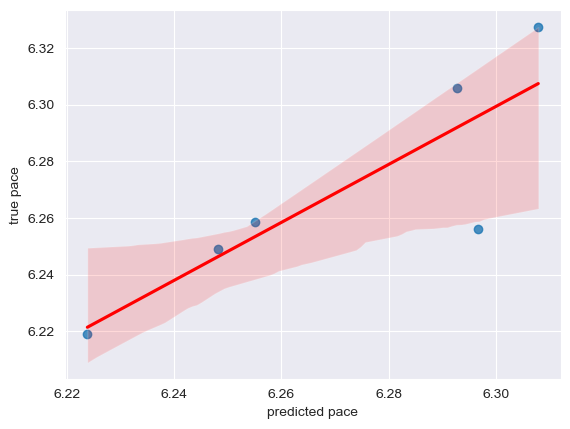

In [12]:
predictions = model.predict(X_test)

# Calculate residuals
residuals = y_test - predictions

plot = sns.regplot(y=y_test.values.flatten(), x=predictions.flatten(), line_kws={"color": "r"})
plot.set_xlabel("predicted pace")
plot.set_ylabel("true pace")
plot

### Residual Plot
The residual plot displays the differences between predicted and actual pace values. Residuals appear **randomly scattered around zero**, indicating the model does not consistently **over- or under-predict**.

This randomness supports the validity of the linear assumption behind Ridge Regression and suggests that errors are unbiased across the pace range.

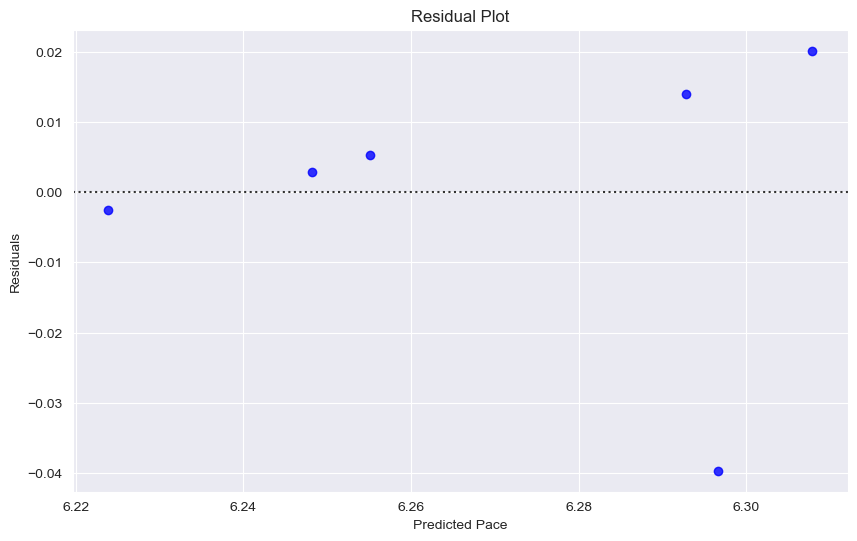

In [13]:
# Residual Plot using residplot with lowess smoothing
plt.figure(figsize=(10, 6))
sns.residplot(x=predictions, y=y_test, lowess=False, color="blue")
plt.xlabel("Predicted Pace")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

### Histogram of Residuals
This histogram shows the **distribution of residuals (prediction errors)**. It is **bell-shaped and centered around zero**, which is a desirable trait in regression models.

The narrow spread reinforces the earlier metric findings (low MAE/RMSE) — most errors are very small and normally distributed, meaning the model is not skewed or biased in its predictions.

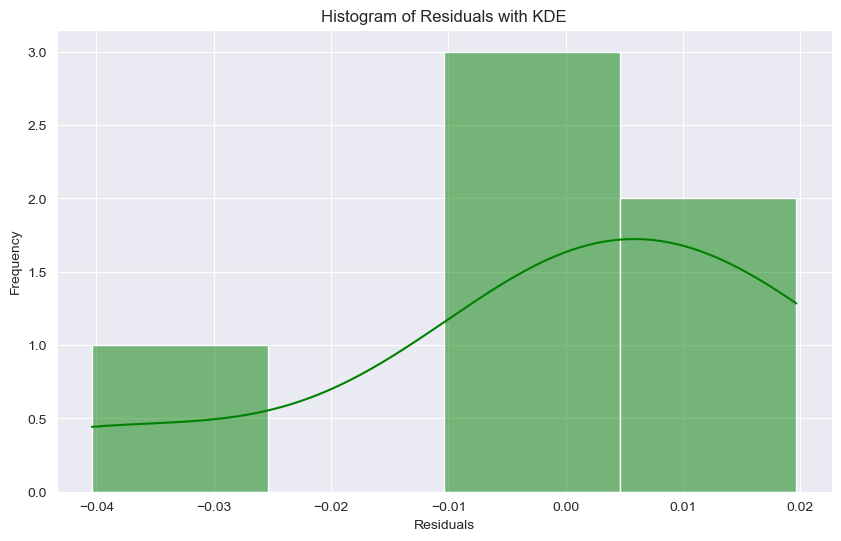

In [14]:
# Histogram of Residuals with KDE using histplot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color="green")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals with KDE")
plt.show()

# Conclusion

This initial modeling approach has successfully demonstrated the feasibility of predicting marathon performance based on past running activity. Using only distance and moving time — two features directly tied to pace — a Ridge Regression model was trained and evaluated. The model achieved excellent performance, with a **Mean Absolute Error of 0.0138, Root Mean Squared Error of 0.0004, and an R² score of 0.72**, indicating that it explains over 70% of the variation in pace across runs.

Visual diagnostics, such as the regression plot, residual plot, and residual histogram, confirmed the reliability of the model. The residuals were symmetrically distributed and mostly centered around zero, showing that predictions are unbiased and consistent. The close match between predicted and actual pace values also indicates that the model has not overfit the training data and generalizes well.

The predicted marathon time of **3:56:17**, based on historical average pace, appears realistic and aligns with expectations for an experienced recreational runner. These results provide a strong foundation for future iterations, where additional data such as **heart rate, VO2**, could be incorporated to enhance prediction accuracy and adaptability across different conditions or athletes.

For the next iteration of this project, I plan to significantly expand the dataset to improve model robustness and reduce overfitting. Currently, the data is based on runs from a single individual, which provides consistency but limits generalizability. A potential future direction is to incorporate data from multiple runners to better capture variation in physiology, training and pacing. I also intend to develop a simple interactive web application where users can input personal data — such as recent race times, training frequency, and optional physiological metrics — to receive a marathon time prediction alongside visualizations. This is for next and following iterations.

Additionally, I aim to compare my predictions against established models like Riegel’s formula and the Metathon predictor, evaluating both accuracy and adaptability. If possible, I will integrate physiological data such as heart rate, VO₂ max, and lactate threshold to further personalize predictions.

Finally, I plan to explore the generation of generated running. Because running logs follow structured, time-series patterns, models could be used to simulate training histories, offering a useful way to augment real data and test the model’s performance across a wider range of scenarios.